# 초기 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import time
import seaborn as sns
import psutil
import cv2

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

import sys

assert sys.version_info >= (3, 7)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)        

1 Physical GPUs, 1 Logical GPUs


# 데이터 불러오기

In [4]:
train_byclass = pd.read_csv('emnist-byclass-train.csv', header=None)
test_byclass = pd.read_csv('emnist-byclass-test.csv', header=None)

In [5]:
s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+l_alph+s_alph)
print(byclass_classes) 

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [6]:
# data label 나누기
X_train = train_byclass.iloc[:, 1:].to_numpy()
train_labels = np.transpose(byclass_classes[train_byclass.iloc[:,0].tolist()])
X_test = test_byclass.iloc[:, 1:].to_numpy()
test_labels = np.transpose(byclass_classes[test_byclass.iloc[:,0].tolist()])

In [7]:
# one-hot coding
y_train = pd.get_dummies(train_labels).to_numpy()
y_test = pd.get_dummies(test_labels).to_numpy()

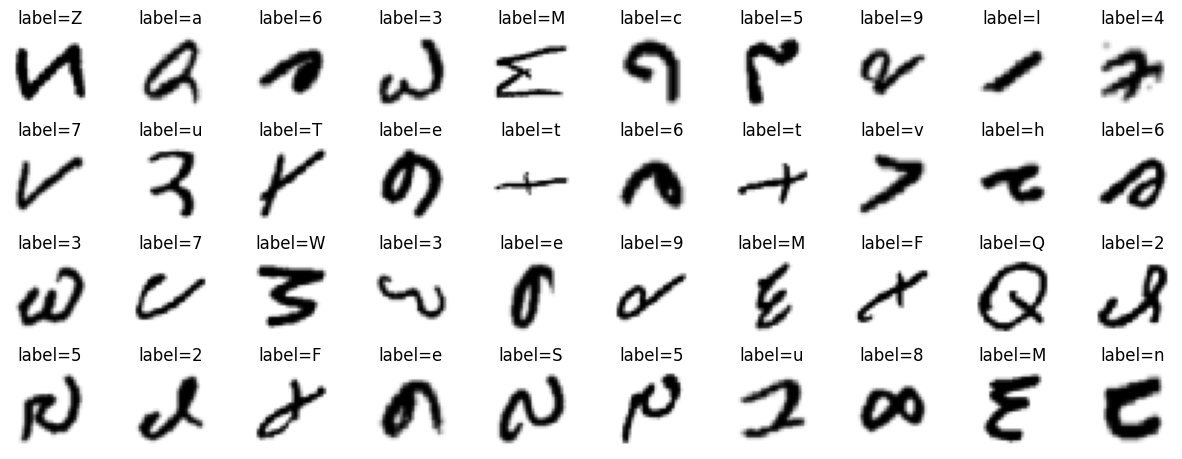

In [8]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={train_labels[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

In [9]:
# 이미지 회전 함수
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])

In [10]:
# 전체 이미지 회전 및 teonsor 형태로 변환
X_train = (np.apply_along_axis(rotate, 1, X_train)/255).reshape(-1, 28, 28, 1).astype(float)
X_test = (np.apply_along_axis(rotate, 1, X_test)/255).reshape(-1, 28, 28, 1).astype(float)

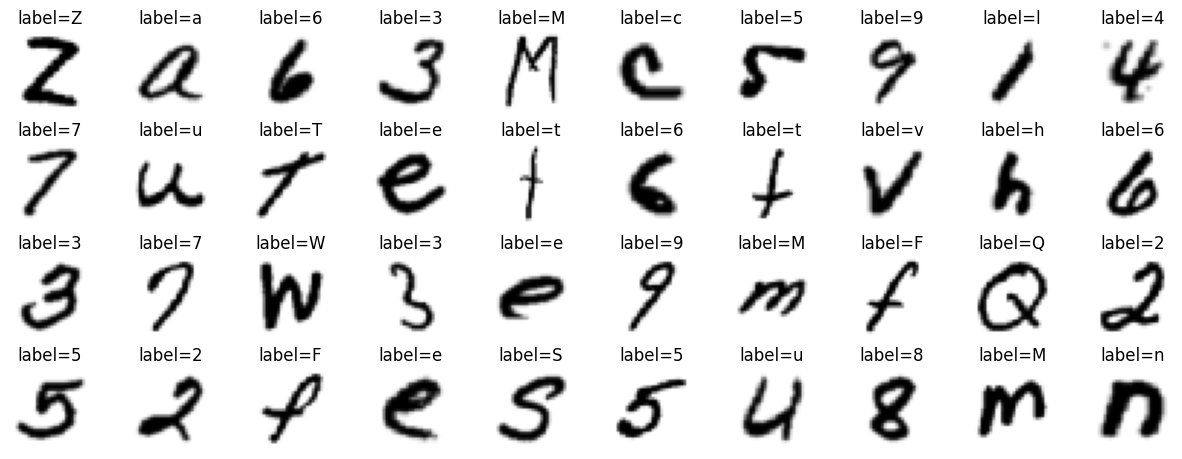

In [11]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={train_labels[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

In [12]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [13]:
del train_byclass, test_byclass, byclass_classes, train_labels, test_labels

In [14]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense, Flatten
from tensorflow.keras.layers import SeparableConv2D, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from PIL import Image 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

from itertools import product

In [15]:
# confusion matrix
def plot_confusion_matrix(cm, class_names, figsize=(8, 8)):
    cm = cm.numpy()
    figure = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_clss=np.transpose(number+l_alph+s_alph)

# Personal Model 

## Basic : relu, lr=1e-3 adam, RLP, batchsize=128,epoch=50

In [16]:
# CNN 인공신경망 정의
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))
    
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
        
    return model

In [17]:
model_basic = create_model()
model_basic.summary()

checkpoint_dir = './model_basic_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                        

In [18]:
start = time.time()
history_basic = model_basic.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3817/3817 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.7987
Epoch 1: val_loss improved from inf to 0.53114, saving model to ./model_basic_checkpoint\cp-01-0.5311.ckpt
3817/3817 [==============================] - 53s 13ms/step - loss: 0.8918 - accuracy: 0.7987 - val_loss: 0.5311 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 2/50
3815/3817 [============================>.] - ETA: 0s - loss: 0.5508 - accuracy: 0.8432
Epoch 2: val_loss improved from 0.53114 to 0.48221, saving model to ./model_basic_checkpoint\cp-02-0.4822.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.5508 - accuracy: 0.8432 - val_loss: 0.4822 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/50
3815/3817 [============================>.] - ETA: 0s - loss: 0.5156 - accuracy: 0.8510
Epoch 3: val_loss improved from 0.48221 to 0.47131, saving model to ./model_basic_checkpoint\cp-03-0.4713.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.5156 - accur

In [22]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_basic.load_weights(latest)
start = time.time()
print(model_basic.evaluate(X_test, y_test, verbose=0))

[0.330249160528183, 0.8847175240516663]


In [23]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1602.435 s
inference time : 8.330 s


In [24]:
model_basic.save("model_basic.h5")

Text(0.5, 1.0, 'Loss Curves')

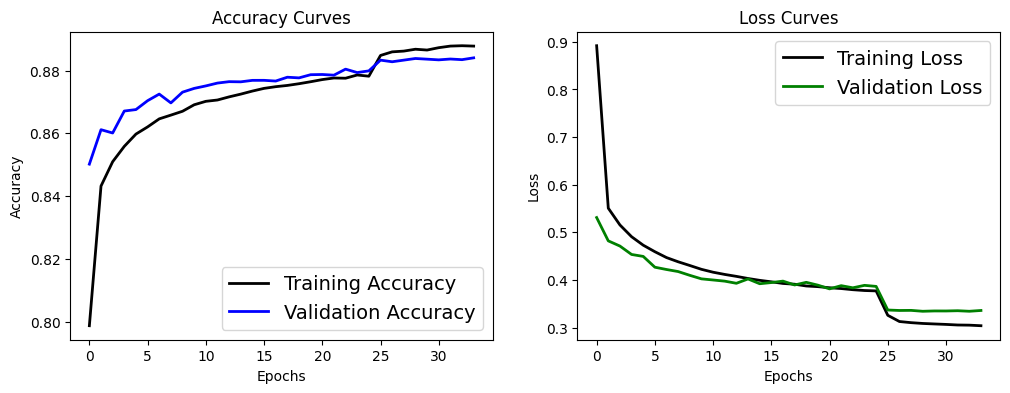

In [25]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_basic.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_basic.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_basic.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_basic.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## relu, lr=3e-4 adam, batchsize=128, epoch=50

In [26]:
model_3e4 = create_model()
model_3e4.summary()

model_3e4.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model_3e4_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)

callbacks_list = [ES, MCP]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [27]:
start = time.time()
history3e4 = model_3e4.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3816/3817 [============================>.] - ETA: 0s - loss: 1.2908 - accuracy: 0.7667
Epoch 1: val_loss improved from inf to 0.48790, saving model to ./model_3e4_checkpoint\cp-01-0.4879.ckpt
3817/3817 [==============================] - 48s 13ms/step - loss: 1.2906 - accuracy: 0.7667 - val_loss: 0.4879 - val_accuracy: 0.8529
Epoch 2/50
3814/3817 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8434
Epoch 2: val_loss improved from 0.48790 to 0.44275, saving model to ./model_3e4_checkpoint\cp-02-0.4427.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.5037 - accuracy: 0.8434 - val_loss: 0.4427 - val_accuracy: 0.8587
Epoch 3/50
3817/3817 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.8529
Epoch 3: val_loss improved from 0.44275 to 0.41980, saving model to ./model_3e4_checkpoint\cp-03-0.4198.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.4629 - accuracy: 0.8529 - val_loss: 0.4198 -

In [28]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_3e4.load_weights(latest)
start = time.time()
print(model_3e4.evaluate(X_test, y_test, verbose=0))

[0.3653358817100525, 0.8785794973373413]


In [29]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 948.432 s
inference time : 8.113 s


In [30]:
model_3e4.save("model_3e4.h5")

Text(0.5, 1.0, 'Loss Curves')

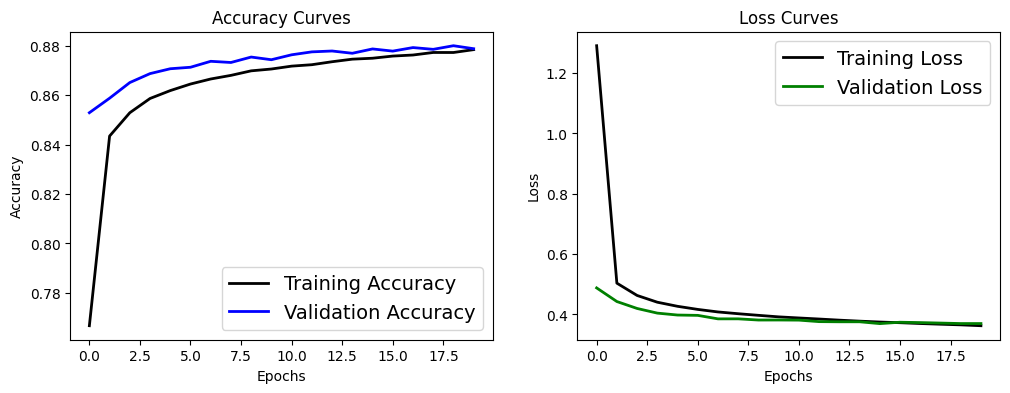

In [31]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history3e4.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history3e4.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history3e4.history['loss'], 'black', linewidth=2.0)
ax2.plot(history3e4.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## relu, lr=5e-3 adam, batchsize=128, epoch=50

In [32]:
model5e3 = create_model()
model5e3.summary()

model5e3.compile(optimizer=Adam(learning_rate=5e-3), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model5e3_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)

callbacks_list = [ES, MCP]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [33]:
start = time.time()
history5e3 = model5e3.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3816/3817 [============================>.] - ETA: 0s - loss: 0.9768 - accuracy: 0.7877
Epoch 1: val_loss improved from inf to 0.69126, saving model to ./model5e3_checkpoint\cp-01-0.6913.ckpt
3817/3817 [==============================] - 48s 12ms/step - loss: 0.9768 - accuracy: 0.7877 - val_loss: 0.6913 - val_accuracy: 0.8386
Epoch 2/50
3815/3817 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.8324
Epoch 2: val_loss improved from 0.69126 to 0.57635, saving model to ./model5e3_checkpoint\cp-02-0.5763.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.6858 - accuracy: 0.8324 - val_loss: 0.5763 - val_accuracy: 0.8560
Epoch 3/50
3813/3817 [============================>.] - ETA: 0s - loss: 0.6101 - accuracy: 0.8417
Epoch 3: val_loss improved from 0.57635 to 0.53122, saving model to ./model5e3_checkpoint\cp-03-0.5312.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.6100 - accuracy: 0.8418 - val_loss: 0.5312 - va

In [34]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model5e3.load_weights(latest)
start = time.time()
print(model5e3.evaluate(X_test, y_test, verbose=0))

[0.4344789385795593, 0.8770148754119873]


In [35]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1176.010 s
inference time : 7.921 s


In [36]:
model5e3.save("model5e3.h5")

Text(0.5, 1.0, 'Loss Curves')

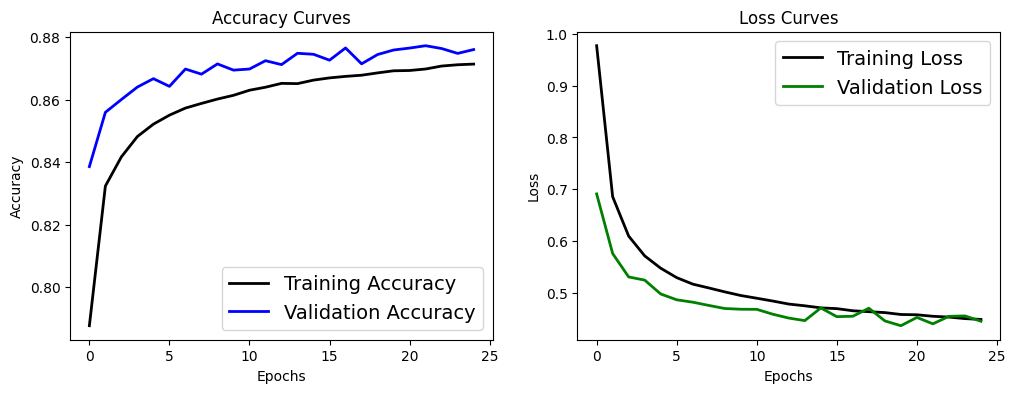

In [37]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history5e3.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history5e3.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history5e3.history['loss'], 'black', linewidth=2.0)
ax2.plot(history5e3.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## relu, lr=5e-4 adam, batchsize=128, epoch=50

In [38]:
model5e4 = create_model()
model5e4.summary()

model5e4.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model5e4_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)

callbacks_list = [ES, MCP]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_27 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_28 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [39]:
start = time.time()
history5e4 = model5e4.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3815/3817 [============================>.] - ETA: 0s - loss: 1.0648 - accuracy: 0.7841
Epoch 1: val_loss improved from inf to 0.49164, saving model to ./model5e4_checkpoint\cp-01-0.4916.ckpt
3817/3817 [==============================] - 48s 12ms/step - loss: 1.0646 - accuracy: 0.7841 - val_loss: 0.4916 - val_accuracy: 0.8533
Epoch 2/50
3813/3817 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.8440
Epoch 2: val_loss improved from 0.49164 to 0.45252, saving model to ./model5e4_checkpoint\cp-02-0.4525.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.5144 - accuracy: 0.8440 - val_loss: 0.4525 - val_accuracy: 0.8611
Epoch 3/50
3817/3817 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.8529
Epoch 3: val_loss improved from 0.45252 to 0.44876, saving model to ./model5e4_checkpoint\cp-03-0.4488.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.4786 - accuracy: 0.8529 - val_loss: 0.4488 - va

In [41]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model5e4.load_weights(latest)
start = time.time()
print(model5e4.evaluate(X_test, y_test, verbose=0))

[0.36762189865112305, 0.8815797567367554]


In [42]:
inference_time = time.time() - start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {inference_time:.3f} s')

train time : 1411.376 s
inference time : 9.192 s


In [43]:
model5e4.save("model5e4.h5")

Text(0.5, 1.0, 'Loss Curves')

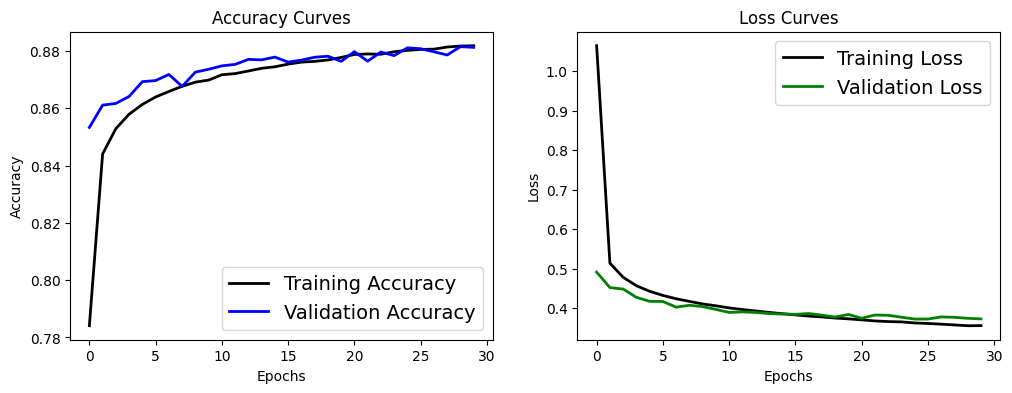

In [44]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history5e4.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history5e4.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history5e4.history['loss'], 'black', linewidth=2.0)
ax2.plot(history5e4.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## relu, lr scheduling onecycle, adam, batchsize=128, epoch=50

In [45]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler
model_cycle = create_model()
model_cycle.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_cycle.summary()

checkpoint_dir = './model_cycle_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
# RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

# One Cycle Policy 설정
num_epochs = 50
num_train_samples = len(X_train)
batch_size = 128
num_steps = num_train_samples // batch_size
lr_schedule = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=0.01,
    step_size=num_steps,
    scale_mode="cycle",
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
)

LRS = LearningRateScheduler(lambda epoch: lr_schedule(epoch).numpy())

callbacks_list = [ES, MCP, LRS]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_36 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_37 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [46]:
start = time.time()
history_cycle = model_cycle.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3813/3817 [============================>.] - ETA: 0s - loss: 2.4351 - accuracy: 0.6882
Epoch 1: val_loss improved from inf to 0.71047, saving model to ./model_cycle_checkpoint\cp-01-0.7105.ckpt
3817/3817 [==============================] - 48s 12ms/step - loss: 2.4334 - accuracy: 0.6883 - val_loss: 0.7105 - val_accuracy: 0.8422 - lr: 1.0000e-04
Epoch 2/50
3814/3817 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.8298
Epoch 2: val_loss improved from 0.71047 to 0.45143, saving model to ./model_cycle_checkpoint\cp-02-0.4514.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.6093 - accuracy: 0.8298 - val_loss: 0.4514 - val_accuracy: 0.8573 - lr: 1.0259e-04
Epoch 3/50
3816/3817 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.8464
Epoch 3: val_loss improved from 0.45143 to 0.40494, saving model to ./model_cycle_checkpoint\cp-03-0.4049.ckpt
3817/3817 [==============================] - 47s 12ms/step - loss: 0.4755

In [47]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_cycle.load_weights(latest)
start = time.time()
print(model_cycle.evaluate(X_test, y_test, verbose=0))

[0.3525967299938202, 0.8798002004623413]


In [48]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1362.173 s
inference time : 8.115 s


In [49]:
model_cycle.save("model_cycle.h5")

Text(0.5, 1.0, 'Loss Curves')

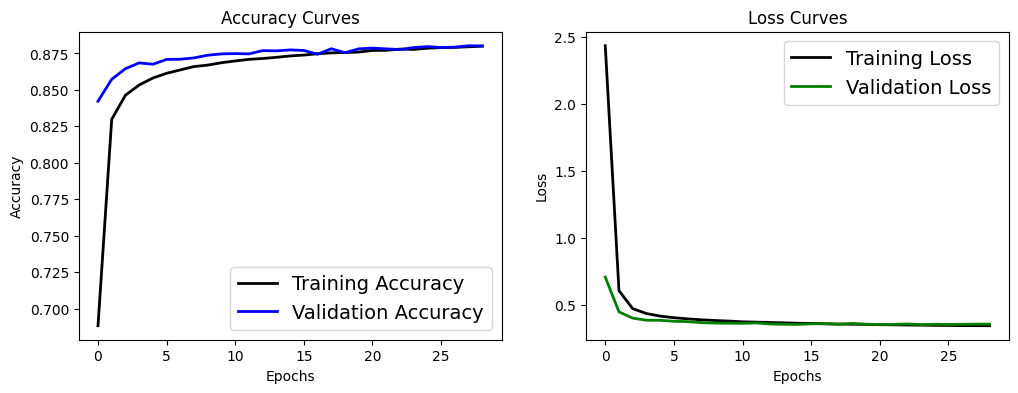

In [50]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_cycle.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_cycle.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_cycle.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_cycle.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# 새로 전처리한 데이터 불러오기

In [51]:
del X_train, y_train, X_val, y_val, X_test, y_test

In [52]:
X_train = np.load("X_byclass_train.npy")
y_train = np.load("y_byclass_train.npy")
X_test = np.load("X_byclass_test.npy")
y_test = np.load("y_byclass_test.npy")

In [53]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

# 데이터 변환

In [54]:
import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.transform import resize

In [55]:
from tensorflow.keras.utils import to_categorical
X_train= X_train.reshape(-1, 28, 28, 1).astype(float)
X_val= X_val.reshape(-1, 28, 28, 1).astype(float)
X_test= X_test.reshape(-1, 28, 28, 1).astype(float)

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [56]:
X_train.shape

(483000, 28, 28, 1)

In [57]:
y_train.shape

(483000, 62)

In [58]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense, Flatten
from tensorflow.keras.layers import SeparableConv2D, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from functools import partial

from itertools import product

# New Model and new data

## relu, lr=1e-3 adam, lr scheduler = RLP

In [59]:
# CNN 인공신경망 정의
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))
    
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
        
    return model

In [60]:
p_model1 = create_model()
p_model1.summary()

checkpoint_dir = './p_model1_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_45 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_46 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [61]:
start = time.time()
history1 = p_model1.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3774/3774 [==============================] - ETA: 0s - loss: 1.1688 - accuracy: 0.7649
Epoch 1: val_loss improved from inf to 0.79168, saving model to ./p_model1_checkpoint\cp-01-0.7917.ckpt
3774/3774 [==============================] - 47s 12ms/step - loss: 1.1688 - accuracy: 0.7649 - val_loss: 0.7917 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 2/50
3773/3774 [============================>.] - ETA: 0s - loss: 0.8163 - accuracy: 0.8070
Epoch 2: val_loss improved from 0.79168 to 0.73860, saving model to ./p_model1_checkpoint\cp-02-0.7386.ckpt
3774/3774 [==============================] - 46s 12ms/step - loss: 0.8162 - accuracy: 0.8070 - val_loss: 0.7386 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 3/50
3770/3774 [============================>.] - ETA: 0s - loss: 0.7824 - accuracy: 0.8147
Epoch 3: val_loss did not improve from 0.73860
3774/3774 [==============================] - 46s 12ms/step - loss: 0.7823 - accuracy: 0.8148 - val_loss: 0.7425 - val_accuracy: 0.8243 - lr: 0.0010
Epo

In [62]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
p_model1.load_weights(latest)
start = time.time()
print(p_model1.evaluate(X_test, y_test, verbose=0))

[0.5796077847480774, 0.8429806232452393]


In [63]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1246.688 s
inference time : 5.957 s


In [64]:
p_model1.save("p_model1.h5")

Text(0.5, 1.0, 'Loss Curves')

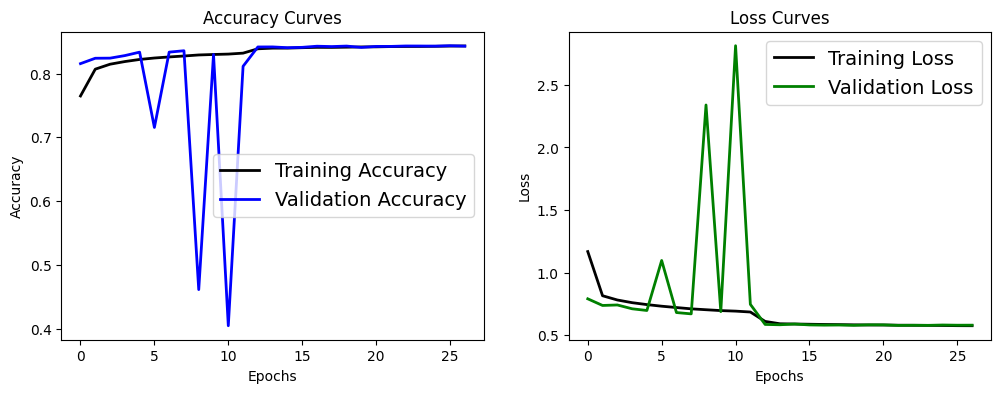

In [65]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history1.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history1.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history1.history['loss'], 'black', linewidth=2.0)
ax2.plot(history1.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## relu, lr=1e-3 nadam, lr schedular = RLP, batchsize=128, epoch=50

In [66]:
# CNN 인공신경망 정의
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))
        
    return model

In [67]:
p_model2 = create_model()
p_model2.summary()

p_model2.compile(optimizer= "Nadam", loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './p_model2_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_54 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_55 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [68]:
start = time.time()
history2 = p_model2.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3774/3774 [==============================] - ETA: 0s - loss: 1.1561 - accuracy: 0.7674
Epoch 1: val_loss improved from inf to 0.80626, saving model to ./p_model2_checkpoint\cp-01-0.8063.ckpt
3774/3774 [==============================] - 109s 29ms/step - loss: 1.1561 - accuracy: 0.7674 - val_loss: 0.8063 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 2/50
3773/3774 [============================>.] - ETA: 0s - loss: 0.8090 - accuracy: 0.8082
Epoch 2: val_loss improved from 0.80626 to 0.74720, saving model to ./p_model2_checkpoint\cp-02-0.7472.ckpt
3774/3774 [==============================] - 108s 29ms/step - loss: 0.8091 - accuracy: 0.8082 - val_loss: 0.7472 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 3/50
3774/3774 [==============================] - ETA: 0s - loss: 0.7777 - accuracy: 0.8155
Epoch 3: val_loss did not improve from 0.74720
3774/3774 [==============================] - 107s 28ms/step - loss: 0.7777 - accuracy: 0.8155 - val_loss: 0.7664 - val_accuracy: 0.8145 - lr: 0.0010


In [69]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
p_model2.load_weights(latest)
start = time.time()
print(p_model2.evaluate(X_test, y_test, verbose=0))

[0.5823932886123657, 0.8423131108283997]


In [70]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 2159.901 s
inference time : 5.950 s


In [71]:
p_model2.save("p_model2.h5")

Text(0.5, 1.0, 'Loss Curves')

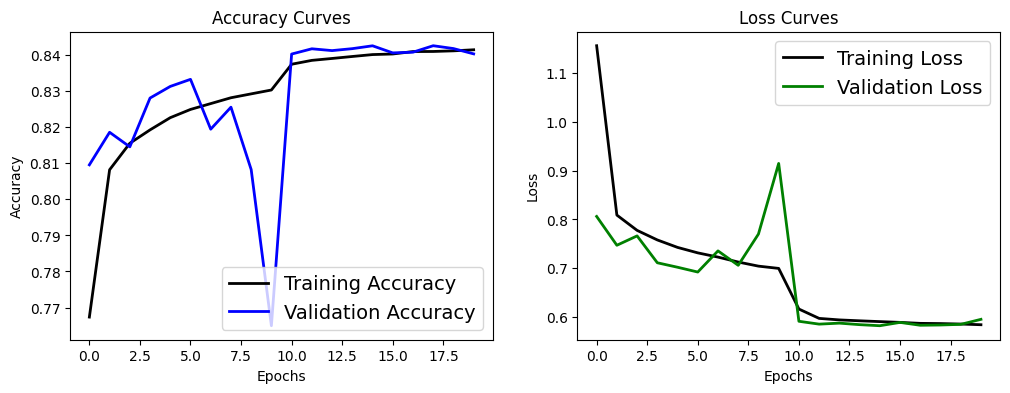

In [72]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history2.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history2.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history2.history['loss'], 'black', linewidth=2.0)
ax2.plot(history2.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## relu, lr=1e-3 RMSProp, lr schedular = RLP, batchsize=128, epoch=50

In [73]:
# CNN 인공신경망 정의
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))
        
    return model

In [74]:
from tensorflow.keras.optimizers import RMSprop
p_model3 = create_model()
p_model3.summary()
optimizer = RMSprop(learning_rate=0.001)
p_model3.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './p_model3_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_63 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_64 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [75]:
start = time.time()
history3 = p_model3.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3773/3774 [============================>.] - ETA: 0s - loss: 1.0894 - accuracy: 0.7764
Epoch 1: val_loss improved from inf to 12.83932, saving model to ./p_model3_checkpoint\cp-01-12.8393.ckpt
3774/3774 [==============================] - 69s 18ms/step - loss: 1.0893 - accuracy: 0.7764 - val_loss: 12.8393 - val_accuracy: 0.0107 - lr: 0.0010
Epoch 2/50
3774/3774 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.8111
Epoch 2: val_loss improved from 12.83932 to 7.54820, saving model to ./p_model3_checkpoint\cp-02-7.5482.ckpt
3774/3774 [==============================] - 68s 18ms/step - loss: 0.8005 - accuracy: 0.8111 - val_loss: 7.5482 - val_accuracy: 0.0285 - lr: 0.0010
Epoch 3/50
3773/3774 [============================>.] - ETA: 0s - loss: 0.7741 - accuracy: 0.8163
Epoch 3: val_loss did not improve from 7.54820
3774/3774 [==============================] - 68s 18ms/step - loss: 0.7741 - accuracy: 0.8163 - val_loss: 28.5467 - val_accuracy: 0.0134 - lr: 0.001

In [76]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
p_model3.load_weights(latest)
start = time.time()
print(p_model3.evaluate(X_test, y_test, verbose=0))

[0.5951186418533325, 0.8410232663154602]


In [77]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1429.123 s
inference time : 6.040 s


In [78]:
p_model3.save("p_model3.h5")

Text(0.5, 1.0, 'Loss Curves')

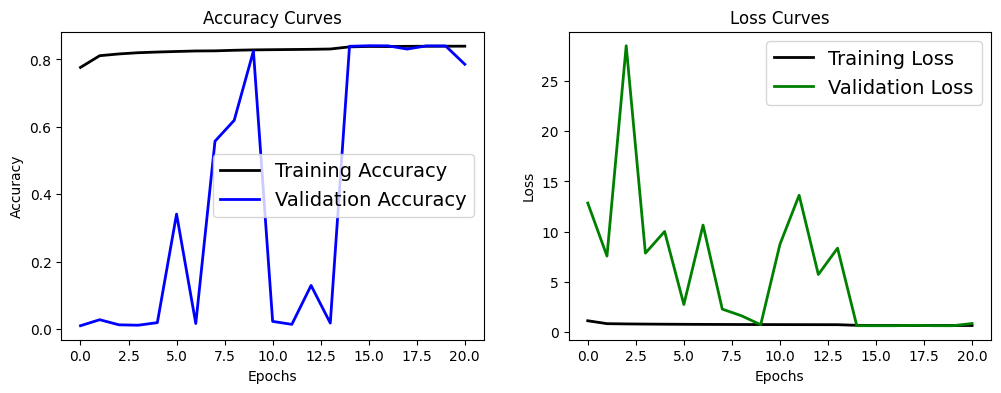

In [79]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history3.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history3.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history3.history['loss'], 'black', linewidth=2.0)
ax2.plot(history3.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## prelu, lr=1e-3 adam, lr scheduler = RLP

In [80]:
# CNN 인공신경망 정의
from tensorflow.keras.layers import PReLU

def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', input_shape=(28,28,1)))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))
        
    return model

In [83]:
p_model4 = create_model()
p_model4.summary()
p_model4.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_dir = './p_model4_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 p_re_lu_8 (PReLU)           (None, 28, 28, 64)        50176     
                                                                 
 batch_normalization_81 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_73 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 p_re_lu_9 (PReLU)           (None, 28, 28, 64)        50176     
                                                                 
 batch_normalization_82 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                     

In [84]:
start = time.time()
history4 = p_model4.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3774/3774 [==============================] - ETA: 0s - loss: 1.1701 - accuracy: 0.7645
Epoch 1: val_loss improved from inf to 0.77551, saving model to ./p_model4_checkpoint\cp-01-0.7755.ckpt
3774/3774 [==============================] - 64s 17ms/step - loss: 1.1701 - accuracy: 0.7645 - val_loss: 0.7755 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 2/50
3771/3774 [============================>.] - ETA: 0s - loss: 0.8083 - accuracy: 0.8086
Epoch 2: val_loss improved from 0.77551 to 0.73352, saving model to ./p_model4_checkpoint\cp-02-0.7335.ckpt
3774/3774 [==============================] - 62s 16ms/step - loss: 0.8083 - accuracy: 0.8086 - val_loss: 0.7335 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 3/50
3772/3774 [============================>.] - ETA: 0s - loss: 0.7739 - accuracy: 0.8158
Epoch 3: val_loss did not improve from 0.73352
3774/3774 [==============================] - 62s 16ms/step - loss: 0.7739 - accuracy: 0.8158 - val_loss: 0.7354 - val_accuracy: 0.8237 - lr: 0.0010
Epo

In [85]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
p_model4.load_weights(latest)
start = time.time()
print(p_model4.evaluate(X_test, y_test, verbose=0))

[0.5823119282722473, 0.8432521820068359]


In [86]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1684.051 s
inference time : 9.751 s


In [87]:
p_model4.save("p_model4.h5")

Text(0.5, 1.0, 'Loss Curves')

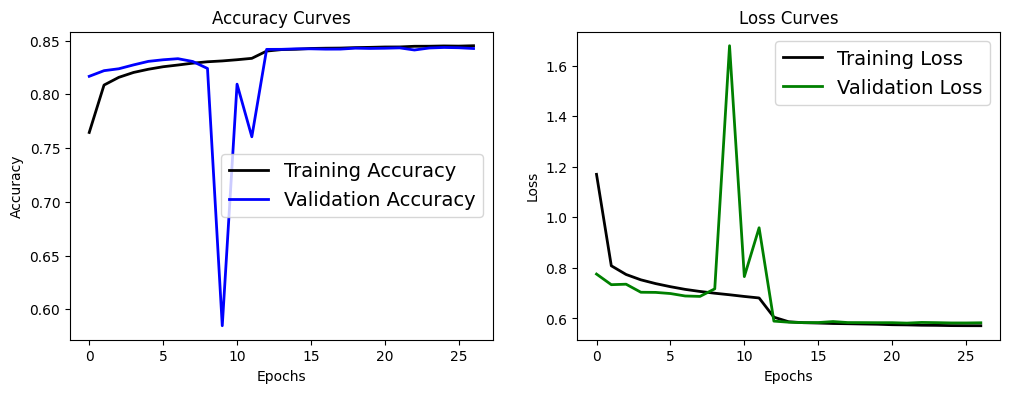

In [88]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history4.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history4.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history4.history['loss'], 'black', linewidth=2.0)
ax2.plot(history4.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## SELU, lr=1e-3 adam, lr schedular = RLP, batchsize=128, epoch=50

In [89]:
# CNN 인공신경망 정의
from tensorflow.keras import initializers
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', activation='selu', input_shape=(28,28,1), kernel_initializer=initializers.lecun_normal()))
    model.add(Conv2D(64, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(Conv2D(128, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(Conv2D(512, (3,3), padding='same', activation='selu', kernel_initializer=initializers.lecun_normal()))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='selu', kernel_initializer=initializers.lecun_normal()))
    model.add(Dense(62, activation='softmax'))
        
    return model

In [90]:
p_model5 = create_model()
p_model5.summary()
p_model5.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './p_model5_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 conv2d_81 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_70 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_82 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_83 (Conv2D)          (None, 14, 14, 128)       147584    
                                                     

In [91]:
start = time.time()
history5 = p_model5.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
3774/3774 [==============================] - ETA: 0s - loss: 1.0616 - accuracy: 0.7528
Epoch 1: val_loss improved from inf to 0.77969, saving model to ./p_model5_checkpoint\cp-01-0.7797.ckpt
3774/3774 [==============================] - 40s 11ms/step - loss: 1.0616 - accuracy: 0.7528 - val_loss: 0.7797 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 2/50
3773/3774 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.7985
Epoch 2: val_loss improved from 0.77969 to 0.76881, saving model to ./p_model5_checkpoint\cp-02-0.7688.ckpt
3774/3774 [==============================] - 39s 10ms/step - loss: 0.8020 - accuracy: 0.7985 - val_loss: 0.7688 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 3/50
3771/3774 [============================>.] - ETA: 0s - loss: 0.7796 - accuracy: 0.8042
Epoch 3: val_loss improved from 0.76881 to 0.72536, saving model to ./p_model5_checkpoint\cp-03-0.7254.ckpt
3774/3774 [==============================] - 39s 10ms/step - loss: 0.7796 - accuracy: 0.80

In [92]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
p_model5.load_weights(latest)
start = time.time()
print(p_model5.evaluate(X_test, y_test, verbose=0))

[0.586517870426178, 0.8376516103744507]


In [93]:
test_time=time.time()-start
print(f'train time : {train_time:.3f} s')
print(f'inference time : {test_time:.3f} s')

train time : 1181.823 s
inference time : 6.000 s


In [94]:
p_model5.save("p_model5.h5")

Text(0.5, 1.0, 'Loss Curves')

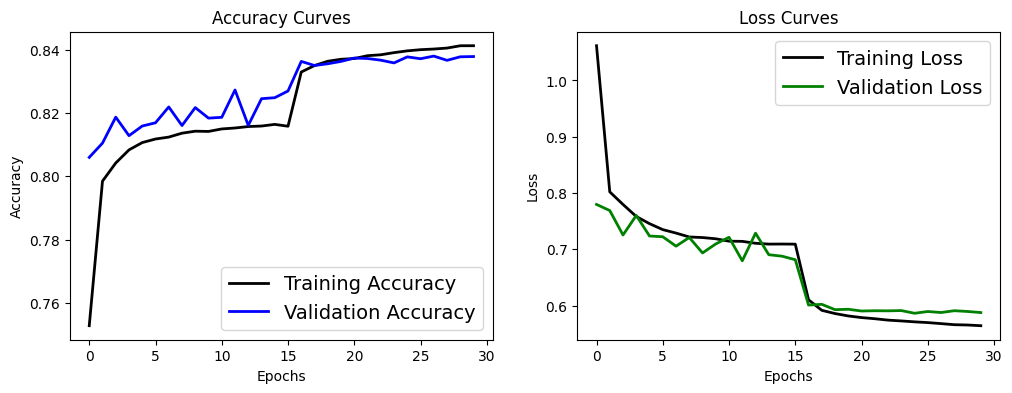

In [95]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history5.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history5.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history5.history['loss'], 'black', linewidth=2.0)
ax2.plot(history5.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)